# Data preprocessing


In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})  

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [95]:
train = pd.read_csv('./dataset/preprocessed_train.csv')
train.head()

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,...,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept
0,1000,2016-03-01,0,1,0,Hyper Market,General,326,7,495,...,0,1,0,0,1,0,0,1,0,0
1,1000,2016-03-02,0,1,0,Hyper Market,General,326,7,608,...,0,0,1,0,1,0,0,1,0,0
2,1000,2016-03-04,0,1,0,Hyper Market,General,326,7,665,...,0,0,0,0,1,0,0,1,0,0
3,1000,2016-03-05,0,1,0,Hyper Market,General,326,7,630,...,0,0,0,0,1,0,0,1,0,0
4,1000,2016-03-07,0,1,1,Hyper Market,General,326,7,763,...,0,0,0,0,1,0,0,1,0,0


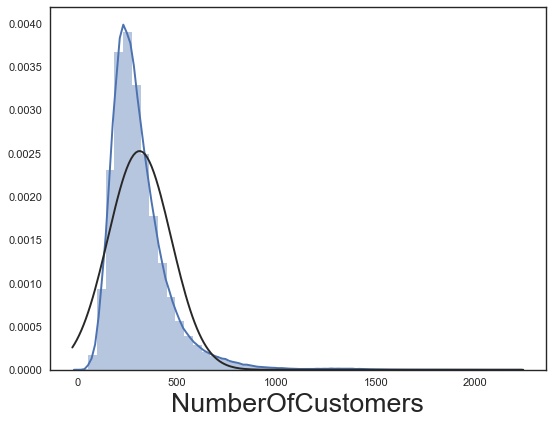

In [96]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
# fit the data with a normal distribution and 
sns.distplot(train['NumberOfCustomers'] , fit=norm)

now we don't have anymore instances where the Store is closed. We visualize again the distribution of 'NumberOfCustomers'

We visualize also the distribution of 'NumberOfSales' considering that the instancies where the Store was closed are already been removed

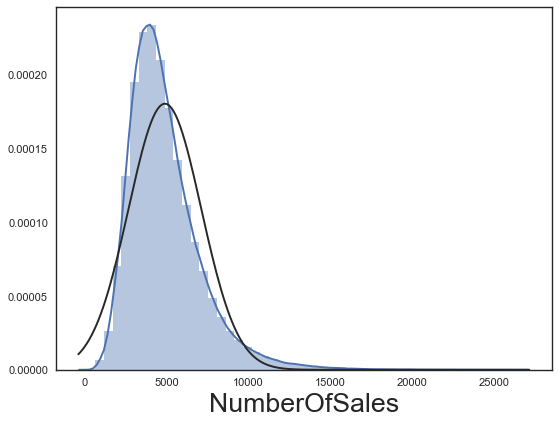

In [97]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
# fit the data with a normal distribution and 
sns.distplot(train['NumberOfSales'] , fit=norm)

## Missing Value

Let's check how many missing values are in the data set and how can we deal with them. 


In [98]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(10)

,Missing Ratio
Max_Gust_SpeedKm_h,78.672631
Events,23.886561
CloudCover,7.847882
Min_VisibilitykM,2.133544
Mean_VisibilityKm,2.133544
Max_VisibilityKm,2.133544


The attribute Max_Gust_SpeedKm_h has too many missing values... We have 2 possibility:
    1)supposing that the missing values mean no Gust and replace them with 0
    2)drop the column and do not take it into account for training

Let's consider the first option for the moment:


Let's see in the training set if there is any correlation between the number of Sales wrt 'Max_Gust_SpeedKm_h' when we impute the missing value with '0'

In [99]:
train['Max_Gust_SpeedKm_h'] = train['Max_Gust_SpeedKm_h'].fillna(0)

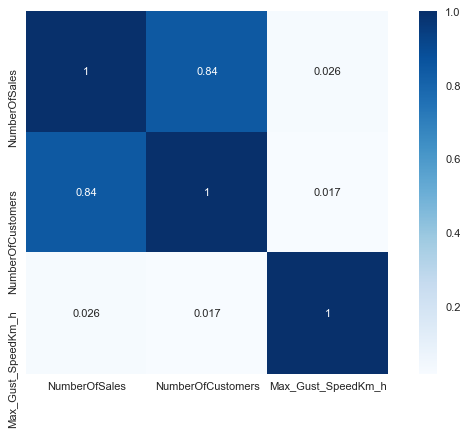

In [100]:
plt.rcParams['figure.figsize'] = [10.0,6.0]
plt.rcParams['figure.dpi']=80
covariance=train[['NumberOfSales','NumberOfCustomers','Max_Gust_SpeedKm_h']].corr(method='pearson')
sns.heatmap(covariance,square=True,annot=True,cmap="Blues")

'Max_Gust_SpeedKm_h seems to have no correlation with the targets.
Considering the fact that the 80% of the values are been imputed following the first option, the best option seems to be not consider that attribute for training.
Let's drop it.

In [101]:
train = train.drop(['Max_Gust_SpeedKm_h'], axis=1)
train.head()

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,...,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept
0,1000,2016-03-01,0,1,0,Hyper Market,General,326,7,495,...,0,1,0,0,1,0,0,1,0,0
1,1000,2016-03-02,0,1,0,Hyper Market,General,326,7,608,...,0,0,1,0,1,0,0,1,0,0
2,1000,2016-03-04,0,1,0,Hyper Market,General,326,7,665,...,0,0,0,0,1,0,0,1,0,0
3,1000,2016-03-05,0,1,0,Hyper Market,General,326,7,630,...,0,0,0,0,1,0,0,1,0,0
4,1000,2016-03-07,0,1,1,Hyper Market,General,326,7,763,...,0,0,0,0,1,0,0,1,0,0


Now that Max_Gust_SpeedKm_h is gone let's continue with the imputation'.
The next attribute is 'Events' with a missing ratio of 24%.
If we analyze the Events we notice that values like 'sunny' never appear so the best option seems to assume that missing values mean no particulare forcasting events.
Let's fill them with the value 'none'.

In [111]:
train["Events"] = train["Events"].fillna("None")

Similarly, noticing that in CloudCover the values range from 1 to 9 but on the library is written that have a range 0-9 we assume that the missing values mean 0 level of covering

In [102]:
train["CloudCover"] = train["CloudCover"].fillna(0)

Now let's analyse Min_VisibilitykM, Mean_VisibilityKm and Max_VisibilityKm

In [103]:
Min_Visibility_missing=train[train.Min_VisibilitykM.isnull()]
Min_Visibility_missing.shape[0]

9258

In [104]:
#we compute the intersection between instances where Min_Visibilityand and Max_Visibility are missing
Max_Visibility_missing=train[train.Max_VisibilityKm.isnull()]
vis=Min_Visibility_missing.merge(Max_Visibility_missing)
vis.shape[0]

9258

In [105]:
#we intersect vis with the instances where Mean_Visibility is missing too
Mean_Visibility_missing=train[train.Mean_VisibilityKm.isnull()]
vis=vis.merge(Mean_Visibility_missing)
vis.shape[0]

9258

we notice that alla the dataframes have the same count. This means that when one of these 3 atributes is missing also the other ones are missing.
We try to understand if the missing triples focus on a particoular region/period/Store because, if that, we have to deal with them carefully to not indroduce bias in the dataset.

In [106]:
# plt.figure(figsize=(8, 6))
# sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
a = iter(list(range(7)))
for i in a:
   # vis_gb=vis.groupby(['Region']).count()
    vis_gb=vis[vis.Region == i]
    print('region %d, number of missing triples:' % i )
    print(vis_gb.shape[0])

region 0, number of missing triples:
546
region 1, number of missing triples:
457
region 2, number of missing triples:
2872
region 3, number of missing triples:
560
region 4, number of missing triples:
37
region 5, number of missing triples:
867
region 6, number of missing triples:
823


the missing triples do not focus on a single region, now we have to impute them.
To do so we can take the median of the region in that particoular day.

In [107]:
train["Mean_VisibilityKm"] = train.groupby(["Region", "Date"])["Mean_VisibilityKm"].transform(lambda x: x.fillna(x.median())).reset_index()



In [108]:
train["Max_VisibilityKm"] = train.groupby("Region")["Max_VisibilityKm"].transform(lambda x: x.fillna(x.median())).reset_index()

In [109]:
train["Min_VisibilitykM"] = train.groupby("Region")["Min_VisibilitykM"].transform(lambda x: x.fillna(x.median())).reset_index()



In [112]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(10)

,Missing Ratio


In [113]:
train.head()

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,...,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept
0,1000,2016-03-01,0,1,0,Hyper Market,General,326,7,495,...,0,1,0,0,1,0,0,1,0,0
1,1000,2016-03-02,0,1,0,Hyper Market,General,326,7,608,...,0,0,1,0,1,0,0,1,0,0
2,1000,2016-03-04,0,1,0,Hyper Market,General,326,7,665,...,0,0,0,0,1,0,0,1,0,0
3,1000,2016-03-05,0,1,0,Hyper Market,General,326,7,630,...,0,0,0,0,1,0,0,1,0,0
4,1000,2016-03-07,0,1,1,Hyper Market,General,326,7,763,...,0,0,0,0,1,0,0,1,0,0


In [114]:
train.to_csv('./dataset/preprocessed_train.csv', index=False)